<a href="https://colab.research.google.com/github/deepsyyt/ML-problem/blob/master/ML_problem_filight_delay_prediction_Regression_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 10.3 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [1]:
# Pre-requisites
import pandas as pd
pd.set_option('display.max_columns', 60)
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# file copy
import shutil

# Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder


# Classifiers from scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

# Performance metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from scipy.stats import pointbiserialr

Reading the flight_df csv file

In [3]:
# the CSV file download
merged_df = pd.read_csv('/content/drive/MyDrive/ML project/merged_df.csv')

Checking the missing values

Axes(0.125,0.11;0.698618x0.77)


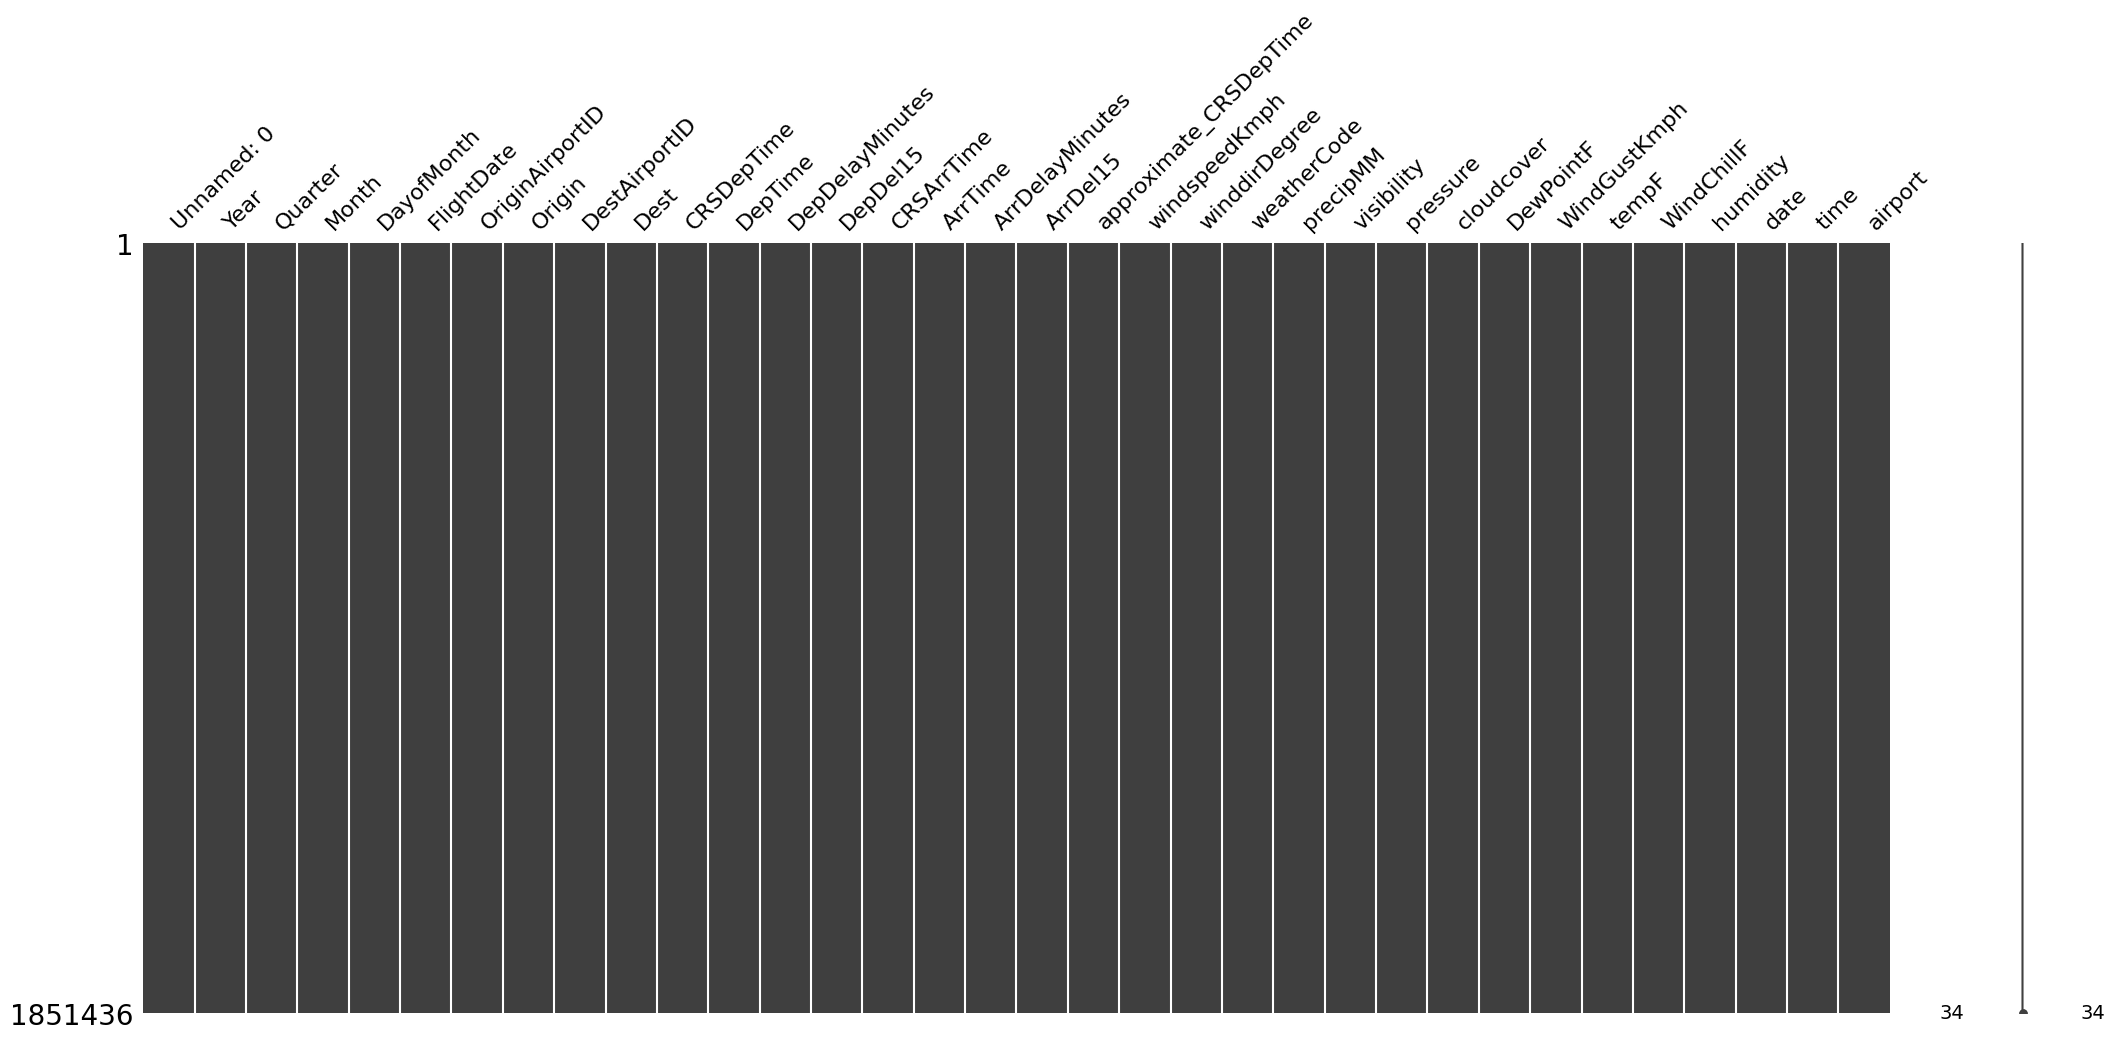

In [4]:
import missingno as msno
merged_df.isna().sum()
print(msno.matrix(merged_df))

In [5]:
merged_df.head()

,Unnamed: 0,Year,Quarter,Month,DayofMonth,FlightDate,OriginAirportID,Origin,DestAirportID,Dest,CRSDepTime,DepTime,DepDelayMinutes,DepDel15,CRSArrTime,ArrTime,ArrDelayMinutes,ArrDel15,approximate_CRSDepTime,windspeedKmph,winddirDegree,weatherCode,precipMM,visibility,pressure,cloudcover,DewPointF,WindGustKmph,tempF,WindChillF,humidity,date,time,airport
0,0,2017,1,1,17,2017-01-17,11057,CLT,14107,PHX,1619,1616.0,0.0,0.0,1856,1842.0,0.0,0.0,1600,15,208,122,0.0,10,1021,96,56,20,62,61,83,2017-01-17,1600,CLT
1,1,2017,1,1,17,2017-01-17,11057,CLT,11618,EWR,1610,1700.0,50.0,1.0,1801,1857.0,56.0,1.0,1600,15,208,122,0.0,10,1021,96,56,20,62,61,83,2017-01-17,1600,CLT
2,2,2017,1,1,17,2017-01-17,11057,CLT,13303,MIA,1619,1614.0,0.0,0.0,1832,1847.0,15.0,1.0,1600,15,208,122,0.0,10,1021,96,56,20,62,61,83,2017-01-17,1600,CLT
3,3,2017,1,1,17,2017-01-17,11057,CLT,12892,LAX,1615,1618.0,3.0,0.0,1852,1823.0,0.0,0.0,1600,15,208,122,0.0,10,1021,96,56,20,62,61,83,2017-01-17,1600,CLT
4,4,2017,1,1,17,2017-01-17,11057,CLT,10397,ATL,1610,1603.0,0.0,0.0,1724,1714.0,0.0,0.0,1600,15,208,122,0.0,10,1021,96,56,20,62,61,83,2017-01-17,1600,CLT


# **Data Preprocessing**


```
Eliminating Redundancy
FlightDate - The columns Year, Month and DayofMonth give this information in separate columns
OriginAirportID, DestAirportID - same as orgin and dest
"CRSArrTime, ArrTime and ArrDel15" - leakage information - target ArrDelayMinutes
approximate_CRSDepTime -It is a duplicate of time
date -It is a duplicate of FlightDate
airport-It is a duplicate of Origin
```


In [6]:
# Dropping columns with redundant or duplicate data
df = merged_df.drop(['Unnamed: 0','OriginAirportID','DestAirportID',"CRSArrTime",
                 "ArrTime", "ArrDel15",'airport','approximate_CRSDepTime','date','time'], axis=1)

# **Feature Engineering**

Creating a binary indicator for weekend flights

In [7]:
# Creating a binary indicator for weekend flights
df['FlightDate'] = pd.to_datetime(df['FlightDate'],format='%Y-%m-%d')
df['DayOfWeek'] = pd.to_datetime(df['FlightDate'], format='%Y-%m-%d').dt.dayofweek
df['DayOfWeekName'] = pd.to_datetime(df['FlightDate'], format='%Y-%m-%d').dt.strftime('%A')
df['DayOfWeek'] = df['DayOfWeek'].astype(int)
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

Handling Multicolinearity by converting or deriving new features from correlated features


In [8]:
#creating new column from the multicolinearity columns to avoid loss of informations
df['AvgWindSpeed'] = (df['windspeedKmph'] + df['WindGustKmph']) / 2
df['AvgTemperature'] = (df['tempF'] + df['WindChillF']) / 2

In [9]:
#dropping redundant features
df_model_regressor = df.drop(['tempF','WindChillF','windspeedKmph','WindGustKmph','FlightDate','DayOfWeek'], axis=1)

In [10]:
df_model_regressor.head()

,Year,Quarter,Month,DayofMonth,Origin,Dest,CRSDepTime,DepTime,DepDelayMinutes,DepDel15,ArrDelayMinutes,winddirDegree,weatherCode,precipMM,visibility,pressure,cloudcover,DewPointF,humidity,DayOfWeekName,IsWeekend,AvgWindSpeed,AvgTemperature
0,2017,1,1,17,CLT,PHX,1619,1616.0,0.0,0.0,0.0,208,122,0.0,10,1021,96,56,83,Tuesday,0,17.5,61.5
1,2017,1,1,17,CLT,EWR,1610,1700.0,50.0,1.0,56.0,208,122,0.0,10,1021,96,56,83,Tuesday,0,17.5,61.5
2,2017,1,1,17,CLT,MIA,1619,1614.0,0.0,0.0,15.0,208,122,0.0,10,1021,96,56,83,Tuesday,0,17.5,61.5
3,2017,1,1,17,CLT,LAX,1615,1618.0,3.0,0.0,0.0,208,122,0.0,10,1021,96,56,83,Tuesday,0,17.5,61.5
4,2017,1,1,17,CLT,ATL,1610,1603.0,0.0,0.0,0.0,208,122,0.0,10,1021,96,56,83,Tuesday,0,17.5,61.5


In [11]:
# checking the below columns for leakage
grouped_data = df_model_regressor[df_model_regressor['ArrDelayMinutes']>15.0].groupby(['DepDel15', 'ArrDelayMinutes']).size().reset_index(name='count')
grouped_data

,DepDel15,ArrDelayMinutes,count
0,0.0,16.0,7350
1,0.0,17.0,6803
2,0.0,18.0,6175
3,0.0,19.0,5541
4,0.0,20.0,4934
...,...,...,...
1228,1.0,1649.0,1
1229,1.0,1711.0,1
1230,1.0,1971.0,1
1231,1.0,2028.0,1


In [12]:
df_model_regressor.to_csv('/content/drive/MyDrive/ML project/df_model_regressor.csv')

In [13]:
df_model_regressor = pd.read_csv('/content/drive/MyDrive/ML project/df_model_regressor.csv',index_col=0).reset_index(drop=True)

In [14]:
df_reg = df_model_regressor[df_model_regressor["ArrDelayMinutes"] > 0]

# **Encoding categorical features**

categorical variable has no ordinal relationship so opting for one hot encoding

In [15]:
#one-hot encoding in pandas
data = pd.get_dummies(df_reg, columns=['Origin', 'Dest','DayOfWeekName'])

In [16]:
data.head()

,Year,Quarter,Month,DayofMonth,CRSDepTime,DepTime,DepDelayMinutes,DepDel15,ArrDelayMinutes,winddirDegree,weatherCode,precipMM,visibility,pressure,cloudcover,DewPointF,humidity,IsWeekend,AvgWindSpeed,AvgTemperature,Origin_ATL,Origin_CLT,Origin_DEN,Origin_DFW,Origin_EWR,Origin_IAH,Origin_JFK,Origin_LAS,Origin_LAX,Origin_MCO,Origin_MIA,Origin_ORD,Origin_PHX,Origin_SEA,Origin_SFO,Dest_ATL,Dest_CLT,Dest_DEN,Dest_DFW,Dest_EWR,Dest_IAH,Dest_JFK,Dest_LAS,Dest_LAX,Dest_MCO,Dest_MIA,Dest_ORD,Dest_PHX,Dest_SEA,Dest_SFO,DayOfWeekName_Friday,DayOfWeekName_Monday,DayOfWeekName_Saturday,DayOfWeekName_Sunday,DayOfWeekName_Thursday,DayOfWeekName_Tuesday,DayOfWeekName_Wednesday
1,2017,1,1,17,1610,1700.0,50.0,1.0,56.0,208,122,0.0,10,1021,96,56,83,0,17.5,61.5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,2017,1,1,17,1619,1614.0,0.0,0.0,15.0,208,122,0.0,10,1021,96,56,83,0,17.5,61.5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
9,2017,1,1,17,1612,1631.0,19.0,1.0,31.0,208,122,0.0,10,1021,96,56,83,0,17.5,61.5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
11,2017,1,1,18,1610,1642.0,32.0,1.0,62.0,306,113,0.0,10,1018,1,44,53,0,18.0,61.5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
24,2017,1,1,19,1625,1731.0,66.0,1.0,64.0,123,116,0.0,10,1017,23,45,61,0,4.5,60.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0


In [17]:
X = data.drop(['ArrDelayMinutes'], axis=1)
y = data['ArrDelayMinutes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Create a StandardScaler for numerical columns
scaler = StandardScaler()

numerical_columns= ['winddirDegree','weatherCode','precipMM','visibility','pressure','cloudcover','DewPointF','humidity','AvgWindSpeed','AvgTemperature']

# Fit and transform on training data
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])

# Transform on test data
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

# **Modeling Different Classifiers**

Linear Regression Regression Metrics:
Mean Squared Error (MSE): 242.8373
Root Mean Squared Error (RMSE): 15.5832
Mean Absolute Error (MAE): 10.5881
R-squared (R2): 0.9343



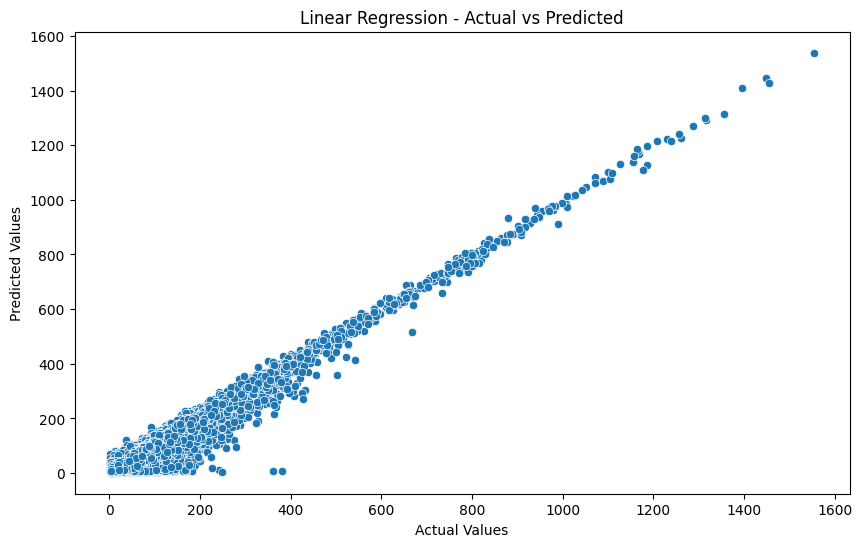

Decision Tree Regressor Regression Metrics:
Mean Squared Error (MSE): 466.5891
Root Mean Squared Error (RMSE): 21.6007
Mean Absolute Error (MAE): 14.4976
R-squared (R2): 0.8737



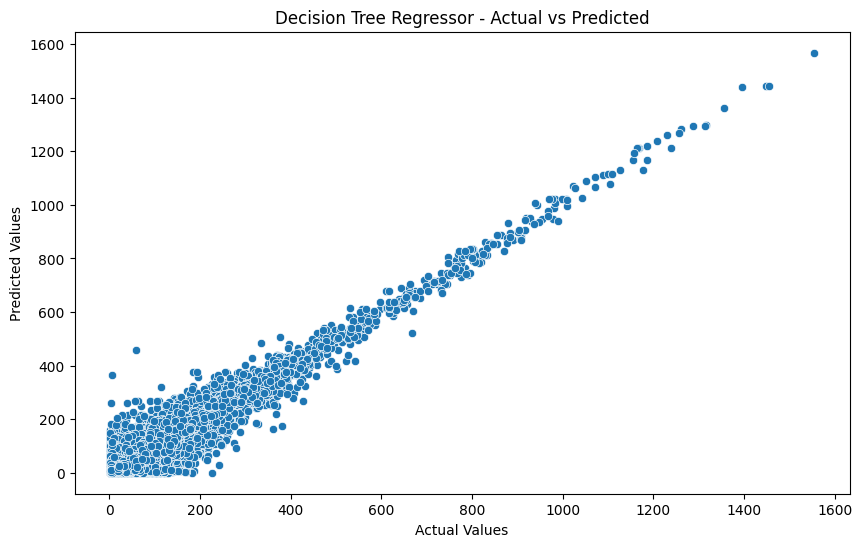

Random Forest Regressor Regression Metrics:
Mean Squared Error (MSE): 224.5645
Root Mean Squared Error (RMSE): 14.9855
Mean Absolute Error (MAE): 10.3555
R-squared (R2): 0.9392



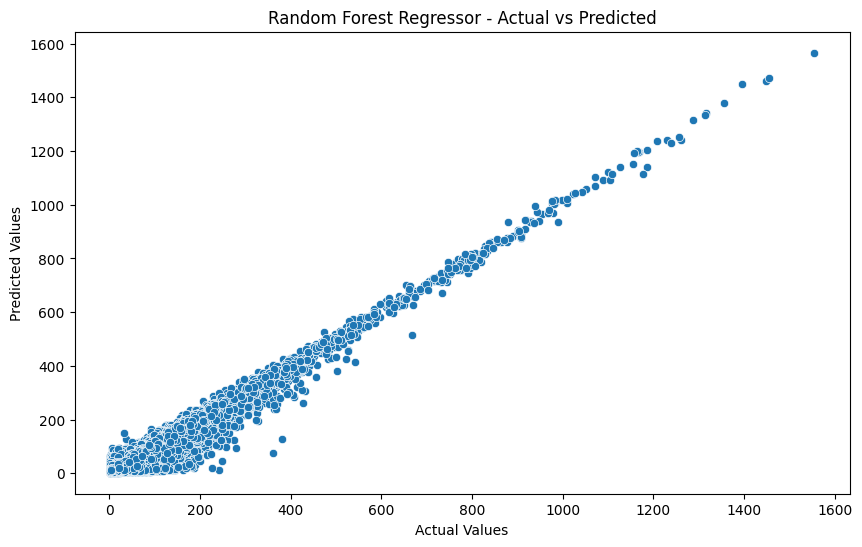

XGBoost Regressor Regression Metrics:
Mean Squared Error (MSE): 221.2208
Root Mean Squared Error (RMSE): 14.8735
Mean Absolute Error (MAE): 10.0566
R-squared (R2): 0.9401



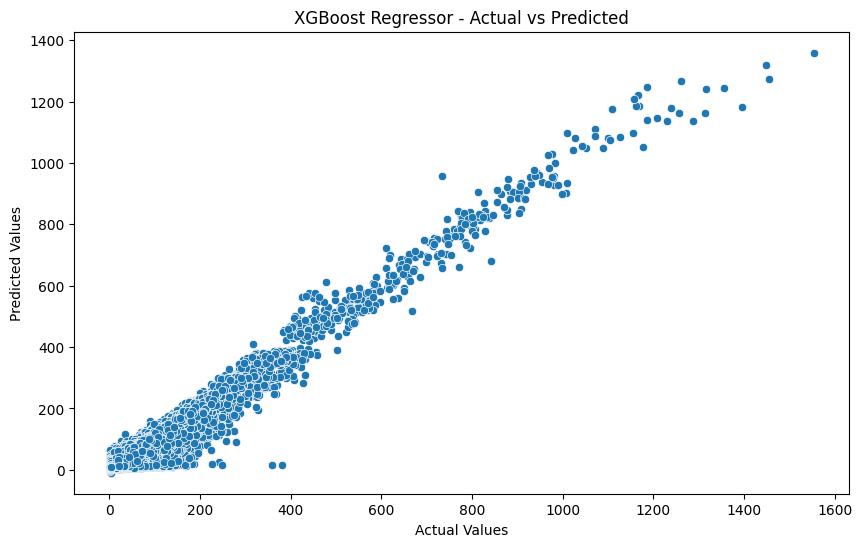

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    # Fit the model
    model.fit(X_train, y_train)

    # Predict on the test set
    model_pred = model.predict(X_test)

    # Calculate regression metrics
    mse = mean_squared_error(y_test, model_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, model_pred)
    r2 = r2_score(y_test, model_pred)

    print(f"{model_name} Regression Metrics:")
    print(f'Mean Squared Error (MSE): {mse:.4f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
    print(f'Mean Absolute Error (MAE): {mae:.4f}')
    print(f'R-squared (R2): {r2:.4f}\n')

    # Plot actual vs predicted values
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_test, y=model_pred)
    plt.title(f"{model_name} - Actual vs Predicted")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.show()

    # Return metrics as a dictionary
    return {
        'Model': model_name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }

# Linear Regression
linear_reg_model = LinearRegression()
linear_reg_metrics = evaluate_model(linear_reg_model, X_train, y_train, X_test, y_test, "Linear Regression")

# Decision Tree Regressor
dt_reg_model = DecisionTreeRegressor()
dt_reg_metrics = evaluate_model(dt_reg_model, X_train, y_train, X_test, y_test, "Decision Tree Regressor")

# Random Forest Regressor
rf_reg_model = RandomForestRegressor()
rf_reg_metrics = evaluate_model(rf_reg_model, X_train, y_train, X_test, y_test, "Random Forest Regressor")

# XGBoost Regressor
xgb_reg_model = XGBRegressor()
xgb_reg_metrics = evaluate_model(xgb_reg_model, X_train, y_train, X_test, y_test, "XGBoost Regressor")

In [20]:
# Create a DataFrame to display the summary
metrics_summary_df = pd.DataFrame([linear_reg_metrics, dt_reg_metrics, rf_reg_metrics, xgb_reg_metrics])
print("\n\nSummary of Regression Metrics:")
print(metrics_summary_df)


Summary of Regression Metrics:
                     Model         MSE       RMSE        MAE        R2
0        Linear Regression  242.837321  15.583238  10.588084  0.934273
1  Decision Tree Regressor  466.589058  21.600673  14.497594  0.873711
2  Random Forest Regressor  224.564467  14.985475  10.355542  0.939218
3        XGBoost Regressor  221.220831  14.873494  10.056586  0.940123
